In [1]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from utils import fft_denoise, wavelet_denoise, compute_metrics
from datasets import ECGDataset
from models import *

model_dict = {
	"U-Net": UNet,
    "ACDAE": ACDAE,
    "DACNN": DACNN,
    "DANCER": DANCER,
}


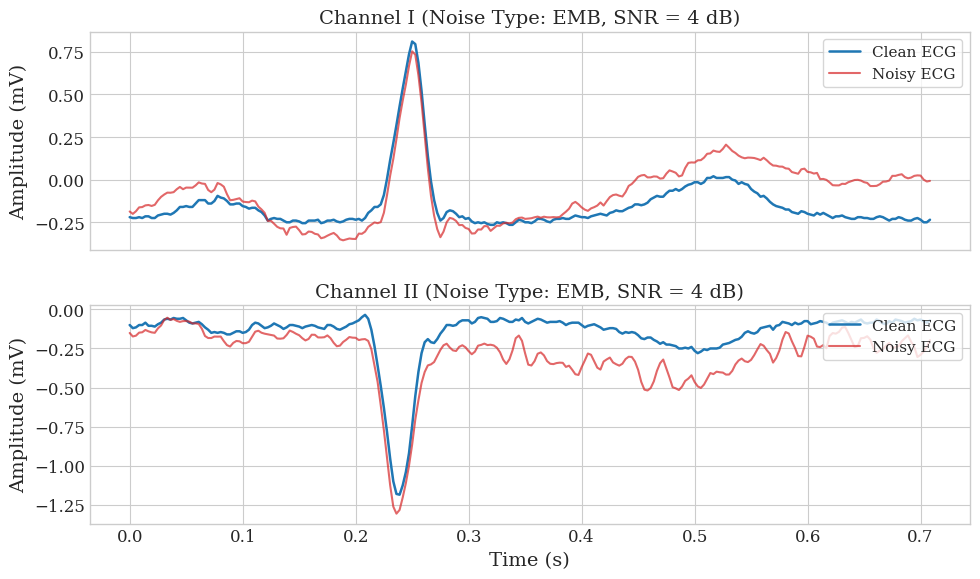

In [ ]:
noise_type = "emb"
snr_db = 4

dataset = ECGDataset(
    split="test",
    noise_type=noise_type,
    snr_db=snr_db,
    split_dir="./data_split",
)

# idx = np.random.randint(0, len(dataset) - 1)
# print(idx)
idx = 860
# idx = 513
noisy, clean = dataset[idx]

mean, std = dataset.get_stats()
mean = mean.squeeze(0).permute(1, 0)
std = std.squeeze(0).permute(1, 0)
ori_noisy = noisy * std + mean


plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "lines.linewidth": 1.5,
})

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

time = np.arange(clean.shape[-1]) / 360


axes[0].plot(time, clean[0].numpy(), color="#1f77b4", label="Clean ECG", linewidth=1.8)
axes[0].plot(time, ori_noisy[0].numpy(), color="#d62728", label="Noisy ECG", alpha=0.7)
axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_title(f"Channel I (Noise Type: {noise_type.upper()}, SNR = {snr_db} dB)")
axes[0].legend(loc="upper right", frameon=True)


axes[1].plot(time, clean[1].numpy(), color="#1f77b4", label="Clean ECG", linewidth=1.8)
axes[1].plot(time, ori_noisy[1].numpy(), color="#d62728", label="Noisy ECG", alpha=0.7)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude (mV)")
axes[1].set_title(f"Channel II (Noise Type: {noise_type.upper()}, SNR = {snr_db} dB)")
axes[1].legend(loc="upper right", frameon=True)

plt.tight_layout(pad=1.2)
plt.subplots_adjust(hspace=0.25)


plt.savefig("ecg_noisy_vs_clean.png", dpi=600, bbox_inches="tight")
plt.show()


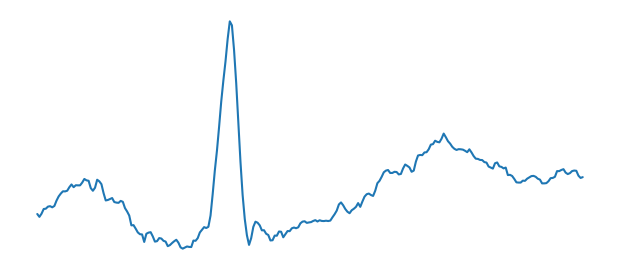

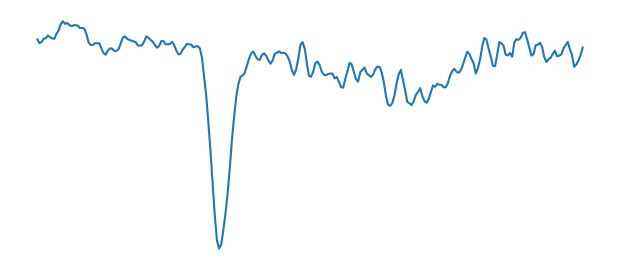

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "lines.linewidth": 1.5,
})


plt.figure(figsize=(6, 2.5))
plt.plot(time, noisy[0].numpy(), color="#1f77b4", linewidth=1.5)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("noisy_ch1_simple.svg", dpi=400, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


plt.figure(figsize=(6, 2.5))
# d62728
plt.plot(time, noisy[1].numpy(), color="#1f77b4", linewidth=1.5)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("noisy_ch2_simple.svg", dpi=400, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [ ]:
# plt.rcParams.update({
#     "font.family": "serif",
#     "font.size": 11,
#     "axes.labelsize": 12,
#     "axes.titlesize": 12,
#     "lines.linewidth": 1.5,
# })

# # channel1
# plt.figure(figsize=(6, 2.5))
# plt.plot(time, clean[0].numpy(), color="#1f77b4", linewidth=1.5)

# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.savefig("clean_ch1_simple.svg", dpi=400, bbox_inches='tight', pad_inches=0, transparent=True)
# plt.show()

# # channel2
# plt.figure(figsize=(6, 2.5))
# plt.plot(time, clean[1].numpy(), color="#1f77b4", linewidth=1.5)

# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.savefig("clean_ch2_simple.svg", dpi=400, bbox_inches='tight', pad_inches=0, transparent=True)
# plt.show()

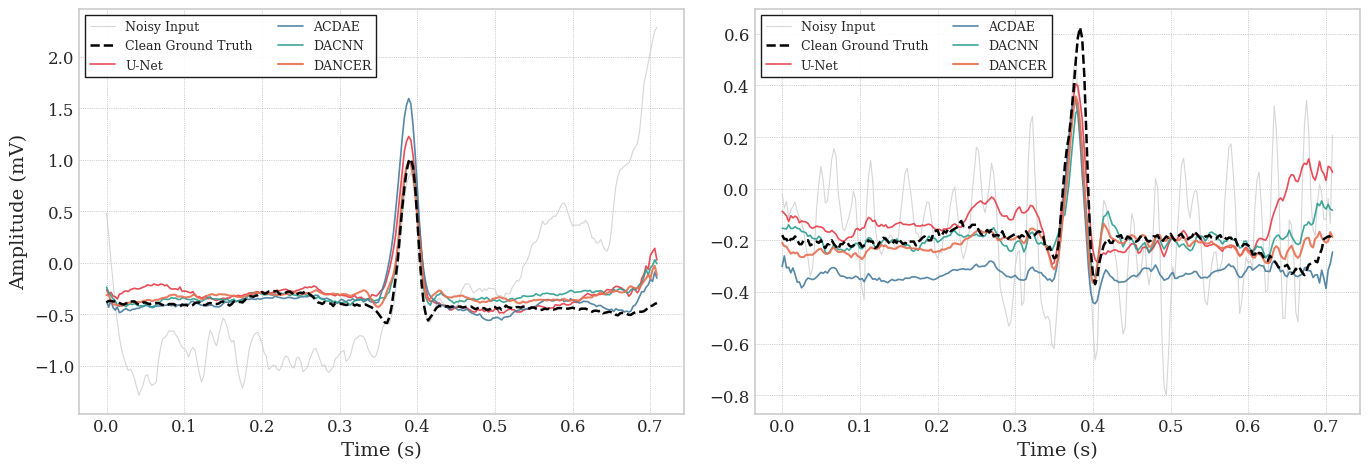

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


import matplotlib.font_manager as font_manager


plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['axes.labelsize'] = 14      
plt.rcParams['xtick.labelsize'] = 12      
plt.rcParams['ytick.labelsize'] = 12      
plt.rcParams['legend.fontsize'] = 11      
plt.rcParams['axes.linewidth'] = 1.2     
plt.rcParams['grid.alpha'] = 0.5          


denoised_output_dict = {}


device = torch.device("cpu") 

for model_name in model_dict.keys():
    model = model_dict[model_name]()

    ckpt_path = f"./checkpoints/best_{model_name}_{noise_type}_snr_{snr_db}.pth"
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    model.eval()

    with torch.no_grad():

        noisy_input = torch.tensor(noisy, dtype=torch.float32).to(device)
        if noisy_input.ndim == 2:
            noisy_input = noisy_input.unsqueeze(0)
        
        denoised_output = model(noisy_input)


    denoised_output = denoised_output.squeeze(0).cpu()
    denoised_output = denoised_output * std + mean
    
    denoised_output_dict[model_name] = denoised_output


t_clean = clean.cpu().numpy()
t_noisy = ori_noisy.cpu().numpy()


time = np.arange(t_clean.shape[-1]) / 360 


colors = {
    "Clean": "#000000",    
    "Noisy": "#cccccc",     
}

model_colors = [
    "#E63946", 
    "#457B9D", 
    "#2A9D8F", 
    "#E76F51", 
    "#8A2BE2", 
]


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=False)


def plot_channel(ax, channel_idx, title):

    ax.plot(time, t_noisy[channel_idx], label="Noisy Input", 
            color=colors["Noisy"], alpha=0.8, linewidth=0.8, zorder=1)
    

    ax.plot(time, t_clean[channel_idx], label="Clean Ground Truth", 
            color=colors["Clean"], linewidth=1.8, linestyle='--', zorder=10)
    

    for i, (model_name, output) in enumerate(denoised_output_dict.items()):
     
        lw = 1.5 if "DANCER" in model_name else 1.2
  
        zo = 5 if "DANCER" in model_name else 3
        
        ax.plot(time, output[channel_idx].numpy(), label=model_name, 
                color=model_colors[i % len(model_colors)], 
                alpha=0.9, linewidth=lw, zorder=zo)

   
    if channel_idx == 0:
        ax.set_ylabel("Amplitude (mV)")
    ax.set_xlabel("Time (s)") 
        
    
    ax.grid(True, linestyle=':', linewidth=0.5, color='gray', alpha=0.7)
    
    
    ax.minorticks_on()
    

    ax.legend(loc='best', ncol=2, frameon=True, 
              edgecolor='black', framealpha=0.9, fancybox=False, fontsize=9)


plot_channel(axes[0], 0, f"Channel I  (Noise: {noise_type.upper()}, SNR = {snr_db} dB)")


plot_channel(axes[1], 1, f"Channel II (Noise: {noise_type.upper()}, SNR = {snr_db} dB)")


plt.tight_layout(pad=1.5)


plt.savefig("ecg_denoising_comparison.svg", format='svg', bbox_inches="tight")


plt.savefig("ecg_denoising_comparison.pdf", format='pdf', bbox_inches="tight")


plt.savefig("ecg_denoising_comparison.png", dpi=600, bbox_inches="tight")

plt.show()